
# Data Insights and Discovery (EDA)
*A hands-on guide to exploring, cleaning, and understanding data before modeling.*

---

## 🎯 Learning Goals
- Load and inspect tabular data
- Understand distributions, relationships, and data quality issues
- Handle missing values and outliers
- Create simple, informative visualizations
- Prepare features for modeling without leakage



## 1️⃣ Why EDA?
Exploratory Data Analysis (EDA) is the **first pass** over your data to:
- Validate assumptions and spot quality issues
- Understand feature distributions and relationships
- Generate hypotheses and guide feature engineering
- Reduce risk of **data leakage** and costly modeling errors

> Good EDA saves time and improves model reliability.



## 2️⃣ Setup & Sample Dataset
We'll synthesize a small dataset that mimics a business setting: predicting **weekly sales** from **ad spends**, **price**, and **store metadata**.


In [1]:

import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

n = 400
df = pd.DataFrame({
    "week": pd.date_range("2023-01-01", periods=n, freq="W"),
    "store_id": rng.integers(1, 21, size=n),
    "ad_spend_tv": rng.normal(10, 3, size=n).clip(0),
    "ad_spend_online": rng.normal(6, 2, size=n).clip(0),
    "price": rng.normal(20, 4, size=n).clip(5),
    "is_holiday": rng.choice([0, 1], size=n, p=[0.85, 0.15]),
})

# Create signal + noise (true function)
true_sales = (
    5
    + 2.2 * df["ad_spend_tv"]
    + 3.0 * df["ad_spend_online"]
    - 0.8 * df["price"]
    + 4.0 * df["is_holiday"]
    + rng.normal(0, 2.5, size=n)
)

df["sales"] = (true_sales).round(2)

# Introduce some missingness & outliers to make EDA realistic
mask_missing = rng.choice([True, False], size=n, p=[0.05, 0.95])
df.loc[mask_missing, "ad_spend_online"] = np.nan
outlier_idx = rng.choice(np.arange(n), size=3, replace=False)
df.loc[outlier_idx, "sales"] *= 4  # extreme outliers

df.head()


,week,store_id,ad_spend_tv,ad_spend_online,price,is_holiday,sales
0,2023-01-01,2,11.929980,4.958823,23.067291,0,27.65
1,2023-01-08,16,8.816185,7.625203,20.484712,0,31.57
2,2023-01-15,14,9.984634,6.483319,20.523057,1,33.25
3,2023-01-22,9,9.509671,2.450076,23.295013,1,14.01
4,2023-01-29,9,11.012724,7.030821,19.762869,0,33.70



## 3️⃣ First Look: Shape, Types, and Basic Stats


In [2]:

df.shape, df.dtypes


((400, 7),
 week               datetime64[ns]
 store_id                    int64
 ad_spend_tv               float64
 ad_spend_online           float64
 price                     float64
 is_holiday                  int64
 sales                     float64
 dtype: object)

In [3]:

df.describe(include="all").T


,count,mean,min,25%,50%,75%,max,std
week,400,2026-10-28 12:00:00,2023-01-01 00:00:00,2024-11-29 06:00:00,2026-10-28 12:00:00,2028-09-25 18:00:00,2030-08-25 00:00:00,NaN
store_id,400.0,10.4225,1.0,6.0,10.0,15.0,20.0,5.652776
ad_spend_tv,400.0,9.937843,1.106413,7.874875,10.009635,11.834092,18.715202,3.040166
ad_spend_online,379.0,5.912823,0.0,4.687367,5.99616,7.114131,12.357707,1.988234
price,400.0,19.953085,8.53178,17.343837,20.024604,22.617623,31.236843,4.06323
is_holiday,400.0,0.155,0.0,0.0,0.0,0.0,1.0,0.362358
sales,400.0,29.85645,-5.93,22.8575,29.215,35.66,209.4,14.885054



## 4️⃣ Data Quality Checks
### Missing Values


In [4]:

df.isna().sum()


week                0
store_id            0
ad_spend_tv         0
ad_spend_online    21
price               0
is_holiday          0
sales               0
dtype: int64


### Handling Missing Values (Simple)
We'll use a simple **median imputation** for `ad_spend_online` as a baseline.


In [5]:

median_online = df["ad_spend_online"].median()
df["ad_spend_online_filled"] = df["ad_spend_online"].fillna(median_online)
df[["ad_spend_online", "ad_spend_online_filled"]].head(10)


,ad_spend_online,ad_spend_online_filled
0,4.958823,4.958823
1,7.625203,7.625203
2,6.483319,6.483319
3,2.450076,2.450076
4,7.030821,7.030821
5,4.844922,4.844922
6,8.548894,8.548894
7,4.744825,4.744825
8,4.726769,4.726769
9,7.082263,7.082263



### Outliers
Let's inspect potential outliers in `sales` via a simple rule of thumb (IQR).


In [6]:

q1, q3 = df["sales"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = df[(df["sales"] < lower) | (df["sales"] > upper)]
len(outliers), outliers[["week","sales"]].head()


(7,
           week  sales
 97  2024-11-10  -5.93
 102 2024-12-15   3.41
 194 2026-09-20   3.65
 250 2027-10-17  58.09
 292 2028-08-06   2.35)


## 5️⃣ Visual Exploration
### Distributions


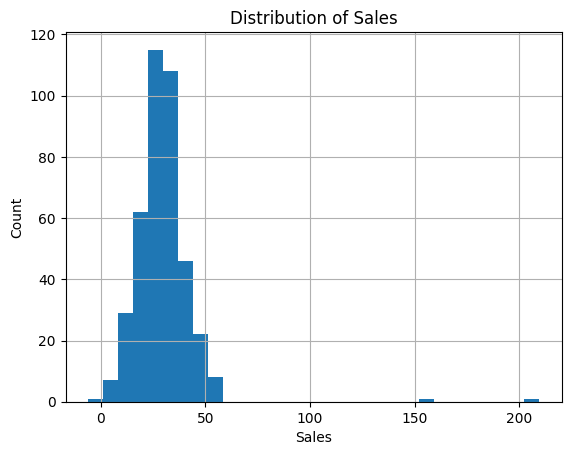

In [7]:

import matplotlib.pyplot as plt

plt.figure()
df["sales"].hist(bins=30)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()


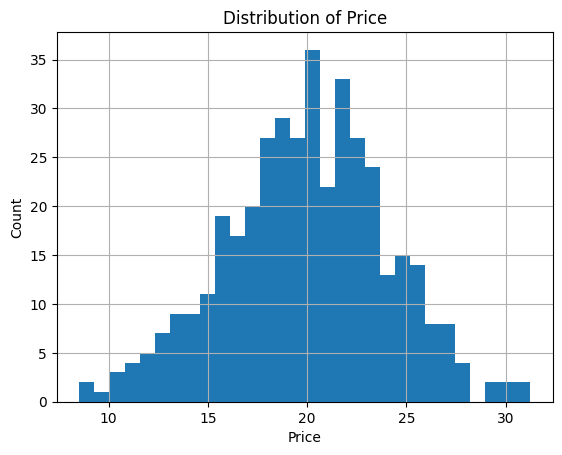

In [8]:

plt.figure()
df["price"].hist(bins=30)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()



### Relationships
Scatter plots help visualize relationships and potential linear trends.


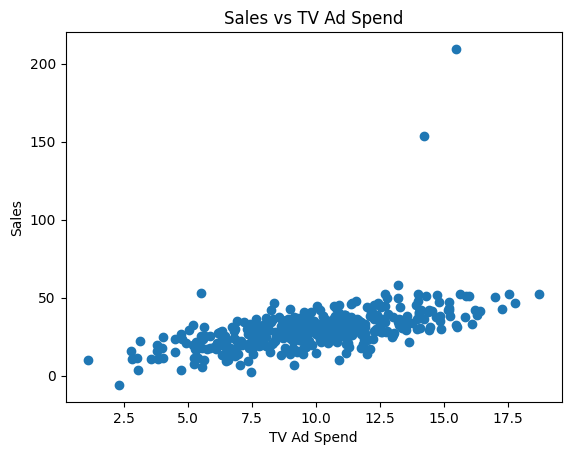

In [9]:

plt.figure()
plt.scatter(df["ad_spend_tv"], df["sales"])
plt.title("Sales vs TV Ad Spend")
plt.xlabel("TV Ad Spend")
plt.ylabel("Sales")
plt.show()


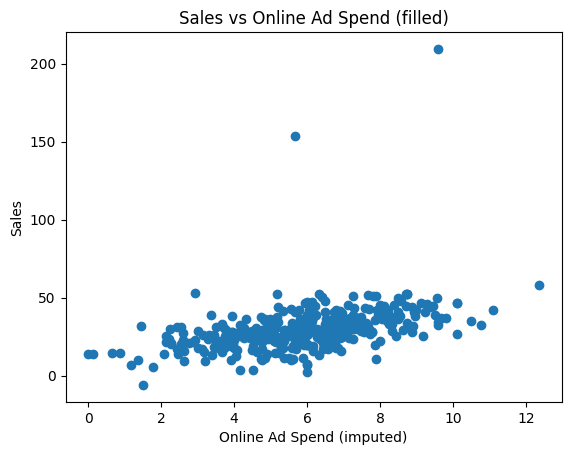

In [10]:

plt.figure()
plt.scatter(df["ad_spend_online_filled"], df["sales"])
plt.title("Sales vs Online Ad Spend (filled)")
plt.xlabel("Online Ad Spend (imputed)")
plt.ylabel("Sales")
plt.show()



## 6️⃣ Correlations
Correlation quantifies linear relationships (−1 to 1).  


In [11]:

corr = df[["sales","ad_spend_tv","ad_spend_online_filled","price","is_holiday"]].corr(numeric_only=True)
corr


,sales,ad_spend_tv,ad_spend_online_filled,price,is_holiday
sales,1.000000,0.522122,0.430987,-0.290665,0.011366
ad_spend_tv,0.522122,1.000000,-0.018996,-0.114734,-0.011867
ad_spend_online_filled,0.430987,-0.018996,1.000000,-0.037556,-0.073438
price,-0.290665,-0.114734,-0.037556,1.000000,0.127581
is_holiday,0.011366,-0.011867,-0.073438,0.127581,1.000000



## 7️⃣ Feature Engineering (Baseline)
- Encode booleans/binaries as integers (already 0/1 here)
- Create interactions where meaningful (e.g., ad spend * holiday)
- Avoid leakage (use only features available at prediction time)


In [12]:

df["spend_total"] = df["ad_spend_tv"] + df["ad_spend_online_filled"]
df["spend_x_holiday"] = df["spend_total"] * df["is_holiday"]
df[["spend_total","spend_x_holiday"]].head()


,spend_total,spend_x_holiday
0,16.888804,0.000000
1,16.441387,0.000000
2,16.467954,16.467954
3,11.959747,11.959747
4,18.043544,0.000000



## 8️⃣ Quick Baseline Model (No Leakage)
We'll build a quick regression to predict `sales` from a few features, using a **time-aware split** to mimic production (train on past, test on future).


In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

df_sorted = df.sort_values("week").reset_index(drop=True)
split = int(len(df_sorted)*0.8)
train, test = df_sorted.iloc[:split], df_sorted.iloc[split:]

features = ["ad_spend_tv", "ad_spend_online_filled", "price", "is_holiday", "spend_total", "spend_x_holiday"]
Xtr, ytr = train[features], train["sales"]
Xte, yte = test[features], test["sales"]

reg = LinearRegression().fit(Xtr, ytr)
pred = reg.predict(Xte)

mae = mean_absolute_error(yte, pred)
r2 = r2_score(yte, pred)
mae, r2


(5.672632017167305, 0.2595335693905477)


### Residuals
Residual diagnostics help spot misspecification and outliers.


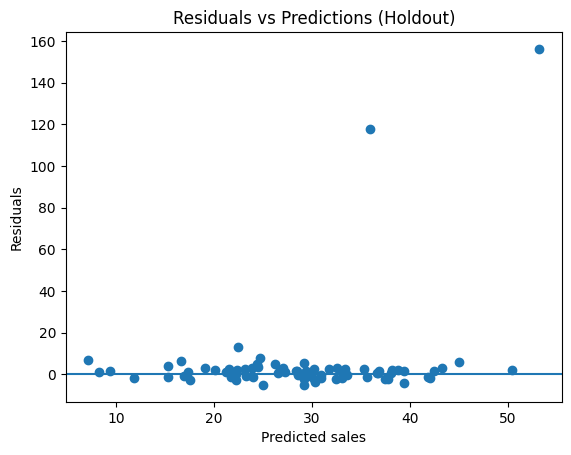

In [14]:

plt.figure()
plt.scatter(pred, yte - pred)
plt.axhline(0)
plt.title("Residuals vs Predictions (Holdout)")
plt.xlabel("Predicted sales")
plt.ylabel("Residuals")
plt.show()



## 9️⃣ EDA Checklist (Practical)
- Validate data types and units
- Check missingness patterns and decide imputation strategy
- Inspect distributions (skew, heavy tails) and outliers
- Examine key relationships (scatter plots)
- Compute correlations (watch for multicollinearity)
- Create candidate features (but avoid leakage)
- Define a **valid split strategy** that matches deployment

> EDA isn't one-and-done. Revisit after each modeling iteration.
